How's it look?

Now with **Mixture model**!

We have orders m111, m113, m114, m115 complete.  Let's plot all of the results on the same figure.

In [1]:
n_o = 20
go = np.arange(99, 119)

In [2]:
n_s = 200
n_ws = 40
n_par = 14+1
wss = np.zeros((n_s*n_ws, n_par, n_o))

In [3]:
for m in go:
    ws = np.load("../sf/m{:03d}/output/mix_emcee/run01/emcee_chain.npy".format(m))
    burned = ws[:, -1.0*n_s:,:]
    xs, ys, zs = burned.shape
    fc = burned.reshape(xs*ys, zs)
    wss[:, :-1, m-99] = fc
    wss[:, -1, m-99] = 10**fc[:,7] / ( 10**fc[:,5] + 10**fc[:,7] )

//anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


I'm pretty sure that what I'm about to do is *not allowed* by probability theory.  
Specifically, I'm "adding probabilities" an operation that is not principled... I think.  
It would be great to ask a statistician about this!
In any case, the result can be considered a consistency check, or an order-weighted average joint probability.

In [4]:
bb = np.array([])
tt = np.array([])

In [5]:
for m in np.arange(20):
    bb = np.append(bb, wss[:,-1, m], axis=0)
    tt = np.append(tt, wss[:,6, m], axis=0)

//anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


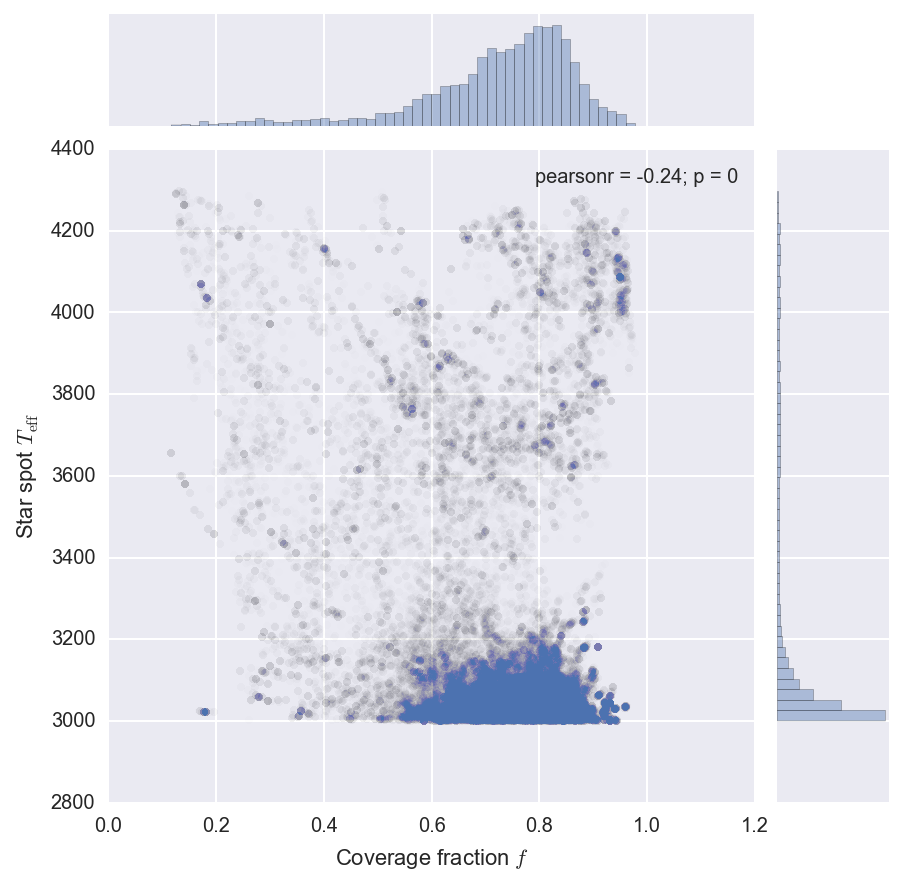

In [6]:
ax = sns.jointplot(bb, tt, kind='scatter', alpha=0.005)
ax.ax_joint.set_ylabel('Star spot $T_{\mathrm{eff}}$')
ax.ax_joint.set_xlabel('Coverage fraction $f$')
#plt.savefig('Star_spot_measurement.pdf', bbox_inches='tight')

This takes a while:

//anaconda/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


//anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


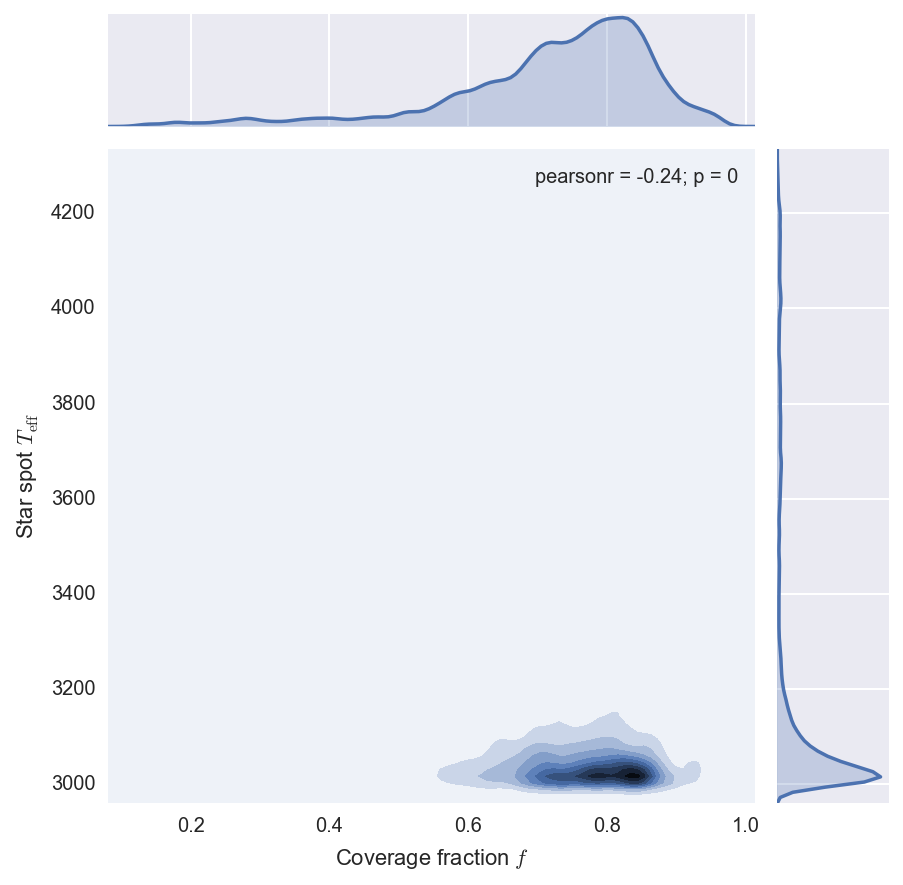

In [7]:
ax = sns.jointplot(bb, tt, kind='kde')
ax.ax_joint.set_ylabel('Star spot $T_{\mathrm{eff}}$')
ax.ax_joint.set_xlabel('Coverage fraction $f$')

# Make a pandas dataframe of the average values from the inference

In [8]:
import pandas as pd

In [9]:
old_df = pd.read_csv('../data/analysis/IGRINS_LkCa4_run01_last20kMCMC.csv')

Copy the metadata columns from the old dataframe:

In [10]:
new_df = old_df[old_df.columns[np.arange(7)]]

What columns do we want?

- All the same as the last array: median and 2 sigma ranges. (6+6)*3 = 36 
- Teff2 and Omega2 and 2 sigma ranges. (1+1)*3 = 6
- Conversion of Omega2 and Omega1 into fill factor and 2 sigma ranges. (1)*3 = 3
- Metadata about the number of samples and the burn-in assumed to compute the above values.
    - We can get more metadata from the `sacct` log from slurm

In [11]:
for col in old_df.columns[7:].values:
    new_df[col] = np.NaN

//anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [49]:
for col in ['Teff2_05p', 'Teff2_50p', 'Teff2_95p']:
    new_df[col] = np.NaN
for col in ['logO2_05p', 'logO2_50p', 'logO2_95p']:
    new_df[col] = np.NaN
for col in ['ff_05p', 'ff_50p', 'ff_95p']:
    new_df[col] = np.NaN

In [50]:
new_df['inference'] = np.NaN

In [51]:
for m in new_df.m_val:
    ind = new_df.index[new_df.m_val == m]
    try:
        ws = np.load("../sf/m{:03d}/output/mix_emcee/run01/emcee_chain.npy".format(m))
        new_df.set_value(ind, 'inference', True)
    except:
        new_df.set_value(ind, 'inference', False)

In [52]:
cs = new_df.columns[7:-5:3]

In [53]:
bases = cs.str[:-4]

In [60]:
bases

Index(['Teff', 'logg', 'FeH', 'vz', 'vi', 'logO', 'c1', 'c2', 'c3', 'SA', 'LA',
       'll', 'Teff2', 'logO2'],
      dtype='object')

In [62]:
base_inds = np.hstack([np.arange(6), np.arange(8, 14), [6, 7]])

In [63]:
base_inds

array([ 0,  1,  2,  3,  4,  5,  8,  9, 10, 11, 12, 13,  6,  7])

In [64]:
base_dict = {key:val for key, val in zip(bases, base_inds)}
suffix_dict = {key:val for key, val in zip(suffixes, [5, 50, 95])}

In [66]:
for m in new_df.m_val[new_df.inference]:
    ind = new_df.index[new_df.m_val == m]
    ws = np.load("../sf/m{:03d}/output/mix_emcee/run01/emcee_chain.npy".format(m))
    burned = ws[:, -1*n_s:,:]
    xs, ys, zs = burned.shape
    fc = burned.reshape(xs*ys, zs)
    bb = 10**fc[:,7] / ( 10**fc[:,5] + 10**fc[:,7] )
    for suffix in suffixes:
        new_df.set_value(ind, 'ff'+suffix, np.percentile(bb, suffix_dict[suffix]))
        for base in bases[:-1]:
            new_df.set_value(ind, base+suffix, np.percentile(fc[:, base_dict[base]], suffix_dict[suffix]))

In [67]:
new_df.head()

,wl_start,wl_end,band,number,tell_trans,m_val,wl_center,Teff_05p,Teff_50p,Teff_95p,...,Teff2_05p,Teff2_50p,Teff2_95p,logO2_05p,logO2_50p,logO2_95p,ff_05p,ff_50p,ff_95p,inference
0,18092,18346,H,0,0.117487,98,18219.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,17914,18165,H,1,0.342583,99,18039.5,3931.021262,4196.127470,4295.104192,...,3007.612092,3061.969155,3199.046408,NaN,NaN,NaN,0.709056,0.818038,0.871110,True
2,17739,17988,H,2,0.666035,100,17863.5,3924.922737,4221.269053,4293.039898,...,3001.564404,3033.193625,3118.474481,NaN,NaN,NaN,0.702850,0.777690,0.842168,True
3,17568,17815,H,3,0.827089,101,17691.5,3808.010328,4155.798016,4276.041452,...,3006.686455,3075.791225,3208.632792,NaN,NaN,NaN,0.704421,0.786773,0.869482,True
4,17400,17645,H,4,0.904758,102,17522.5,4037.643678,4240.880406,4294.305977,...,3001.559295,3025.211248,3082.416705,NaN,NaN,NaN,0.801685,0.840407,0.920849,True


In [69]:
new_df.to_csv('../data/analysis/IGRINS_mix_emcee_last200.csv', index=False)

In [70]:
vals = np.array([1,2,3])

The end.